# Create instances of Data from Gaussian mocks

In [1]:
import time

import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction
from pypower import CatalogMesh, ArrayMesh
from pypower.fft_power import project_to_basis
from mockfactory import EulerianLinearMock, LagrangianLinearMock, RandomBoxCatalog, setup_logging

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import damping_function
from densitysplit.utils import *
from densitysplit.corr_func_utils import *
from densitysplit.split_model import *

## Cosmology

In [2]:
z = 1.175

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

k=np.logspace(-5, 3, 1000000)

## Data and output directories

In [3]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/mocks/gaussian/'

In [5]:
xi_list = list()
s = np.load(output_dir+'AbacusSummit_1Gpc_z1.175_10_gaussianMocks_truncatedPk_nbarx5_xi_from_delta_r_sep.npy')

for i in range(0, 10):
    xi = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_gaussianMock{}_truncatedPk_nbar0.01_xi_from_delta_r.npy'.format(i))
    xi_list.append(xi)
    
xi_FFT_delta_r = np.array(xi_list)

In [5]:
shot_noise_list = list()

for i in range(0, 100):
    mock_catalog = catalog_data.Data.load(output_dir+'AbacusSummit_1Gpc_z1.175_gaussianMock{}_truncatedPk_nbarx5.npy'.format(i))
    nbar = mock_catalog.size/mock_catalog.boxsize**3
    shot_noise_list.append(np.mean((mock_catalog.weights)**2)/nbar)

In [6]:
shot_noise = np.mean(shot_noise_list)

In [7]:
shot_noise

404.18271396641967

In [8]:
xi_FFT_particles = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_cellsize10_estimated2PCF.npy')

## Model

In [9]:
kN = np.pi*512/1000

In [10]:
pklin = cosmo_abacus.get_fourier().pk_interpolator(extrap_kmin=1e-6, extrap_kmax=1e3).to_1d(z)
pklin_array = pklin(k)
pkdamped_func = lambda k: pklin(k) * np.array([damping_function(kk) for kk in k])
pkdamped = PowerSpectrumInterpolator1D.from_callable(k, pkdamped_func)

In [11]:
model = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1, shot_noise=shot_noise)
model.set_pk_model(pk=pkdamped)

In [7]:
ells = [0]
nells = len(ells)

In [8]:
poles_FFT_delta_r = np.mean(xi_FFT_delta_r, axis=0)
xiell_FFT_delta_r = poles_FFT_delta_r.reshape((nells, len(poles_FFT_delta_r)//nells))
cov_FFT_delta_r = np.cov(xi_FFT_delta_r, rowvar=False)
std_FFT_delta_r = np.array(np.array_split(np.diag(cov_FFT_delta_r)**0.5, nells))/np.sqrt(100)

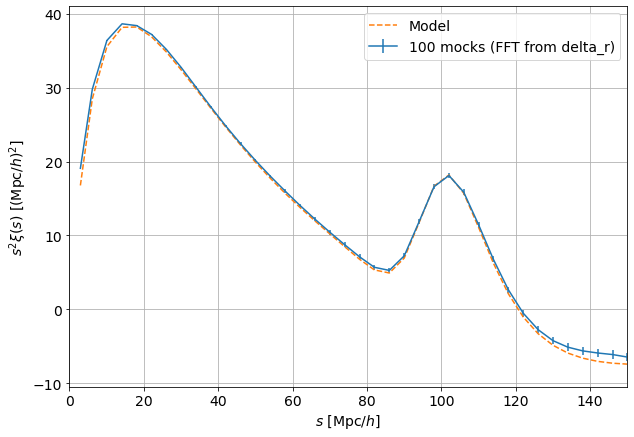

In [21]:
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size': 14})

for ill, ell in enumerate(ells):
    #plt.errorbar(s, s**2 * xiell_FFT_particles[ill], s**2 * std_FFT_particles[ill], fmt='-', label = r'Mocks (FFT from particles)')
    plt.errorbar(s, s**2 * xiell_FFT_delta_r[ill], s**2 * std_FFT_delta_r[ill], fmt='-', label = r'100 mocks (FFT from delta_r)')
    #plt.errorbar(mocks_s1, mocks_s1**2 * mocks_xiell1[ill], mocks_s1**2 * mocks_std1[ill], fmt='-', label = r'Mocks (pair counts)')
    plt.plot(s, s**2 * model.xi(s), label = 'Model', ls='--')
    plt.grid(True)

plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlim((0, 150))
plt.legend()
plt.show()

In [14]:
poles_FFT_particles = np.mean(xi_FFT_particles, axis=0)
xiell_FFT_particles = poles_FFT_particles.reshape((nells, len(poles_FFT_particles)//nells))
cov_FFT_particles = np.cov(xi_FFT_particles, rowvar=False)
std_FFT_particles = np.array(np.array_split(np.diag(cov_FFT_particles)**0.5, nells))/np.sqrt(10)

In [15]:
mocks_results1 = np.load('/feynman/work/dphp/mp270220/outputs/correlation_functions/'+'AbacusSummit_1Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_cellsize10_2PCF.npy', allow_pickle=True)
mocks_xiell1, mocks_cov1 = get_poles(mocks_results1, ells)
mocks_std1 = np.array(np.array_split(np.diag(mocks_cov1)**0.5, nells))/np.sqrt(10)
mocks_s1, _, res = mocks_results1[0].get_corr(return_sep=True)

In [16]:
mocks_results2 = np.load('/feynman/work/dphp/mp270220/outputs/'+'AbacusSummit_2Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_cellsize10_2PCF.npy', allow_pickle=True)
mocks_xiell2, mocks_cov2 = get_poles(mocks_results2, ells)
mocks_std2 = np.array(np.array_split(np.diag(mocks_cov2)**0.5, nells))/np.sqrt(10)
mocks_s2, _, res = mocks_results2[0].get_corr(return_sep=True)

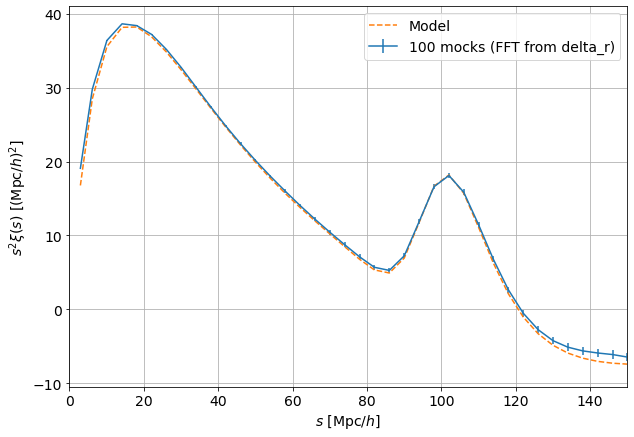

In [21]:
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size': 14})

for ill, ell in enumerate(ells):
    #plt.errorbar(s, s**2 * xiell_FFT_particles[ill], s**2 * std_FFT_particles[ill], fmt='-', label = r'Mocks (FFT from particles)')
    plt.errorbar(s, s**2 * xiell_FFT_delta_r[ill], s**2 * std_FFT_delta_r[ill], fmt='-', label = r'100 mocks (FFT from delta_r)')
    #plt.errorbar(mocks_s1, mocks_s1**2 * mocks_xiell1[ill], mocks_s1**2 * mocks_std1[ill], fmt='-', label = r'Mocks (pair counts)')
    plt.plot(s, s**2 * model.xi(s), label = 'Model', ls='--')
    plt.grid(True)

plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlim((0, 150))
plt.legend()
plt.show()

In [19]:
s[10:]

array([ 42.08120739,  46.0684758 ,  50.05180356,  54.06880245,
        58.06608122,  62.03357657,  66.04184795,  70.03830615,
        74.0308162 ,  78.03105431,  82.01049137,  86.03038804,
        90.04377646,  94.02704458,  98.04287423, 102.04899252,
       106.02651957, 110.01799388, 114.01570218, 118.02911663,
       122.0393824 , 126.03591168, 130.02705659, 134.00694827,
       138.01490136, 142.02425138, 146.03341913, 150.02508421,
       154.01079858, 158.01925234, 162.02195062, 166.01909534,
       170.02105198, 174.02290055, 178.01894326, 182.02769843,
       186.01954862, 190.00161317, 194.01376592, 198.02190511])

In [18]:
def compute_chi2(y_exp, y_model, errors):
    res = ((y_exp-y_model)/errors)**2
    return np.sum(res)

chi2 = compute_chi2(xiell_FFT_delta_r[0][10:], model.xi(s)[10:], std_FFT_delta_r[0][10:])
ndof = len(s[10:])
print(chi2)
print(chi2/ndof)

42.544269274900564
1.0636067318725142


In [20]:
import scipy.stats
scipy.stats.chi2.sf(chi2, ndof)

0.36208959278927855

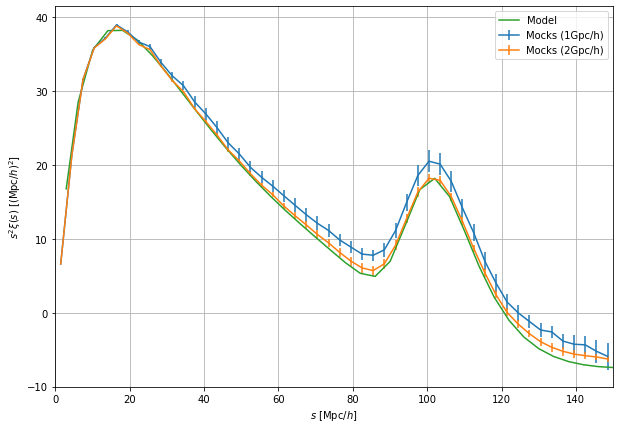

In [40]:
plt.rcParams["figure.figsize"] = (10, 7)

for ill, ell in enumerate(ells):
    plt.errorbar(mocks_s1, mocks_s1**2 * mocks_xiell1[ill], mocks_s1**2 * mocks_std1[ill], fmt='-', label = r'Mocks (1Gpc/h)')
    plt.errorbar(mocks_s2, mocks_s2**2 * mocks_xiell2[ill], mocks_s2**2 * mocks_std2[ill], fmt='-', label = r'Mocks (2Gpc/h)')
    plt.plot(s, s**2 * model.xi(s), label = 'Model', ls='-')
    plt.grid(True)

plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlim((0, 150))
plt.legend()
plt.show()